# Fat tails and their impact on option prices

## Kurtosis, defining fat tails and counter-intuitive results

Option trading is usually associated with the words 'convexity' or 'leverage' with the assumption being that options are the best instrument to profit from large stock price moves - either positive or negative. This opinion has been spurred on by depictions of optionality in movies such as the Big Short (Michael Burry and his CDSs) as well as popular commentary in January 2021 on the furore around WallStreetBets and their interest in GameStop.

Whilst options certainly do display leverage, the notion that all options gain from large price moves isn't quite true. The aim of this article is to qualify this statement by:
 - defining what we mean mathematically by 'large' price moves
 - constructing a variety of distributions that display varying propensity to generate these 'large' moves
 - comparing option prices when priced in accordance with these distributions

## Fat tails

'Large' price moves can only be deemed 'large' if in comparison to something else. A standard daily move on one stock or index may be considered 'large' for another if the other stock or index is much less volatile to begin with.

Stock price moves are commonly referred to as 'returns', in particular log returns, and we can take a sample of these and plot their frequency as a histogram. In doing so we can get an indication of what we consider to be a 'standard move' - something that happens a lot of the time - and then we can define what constitutes a 'large move' in reference to that.

For illustration we can do that with the SPX daily return series below in python.

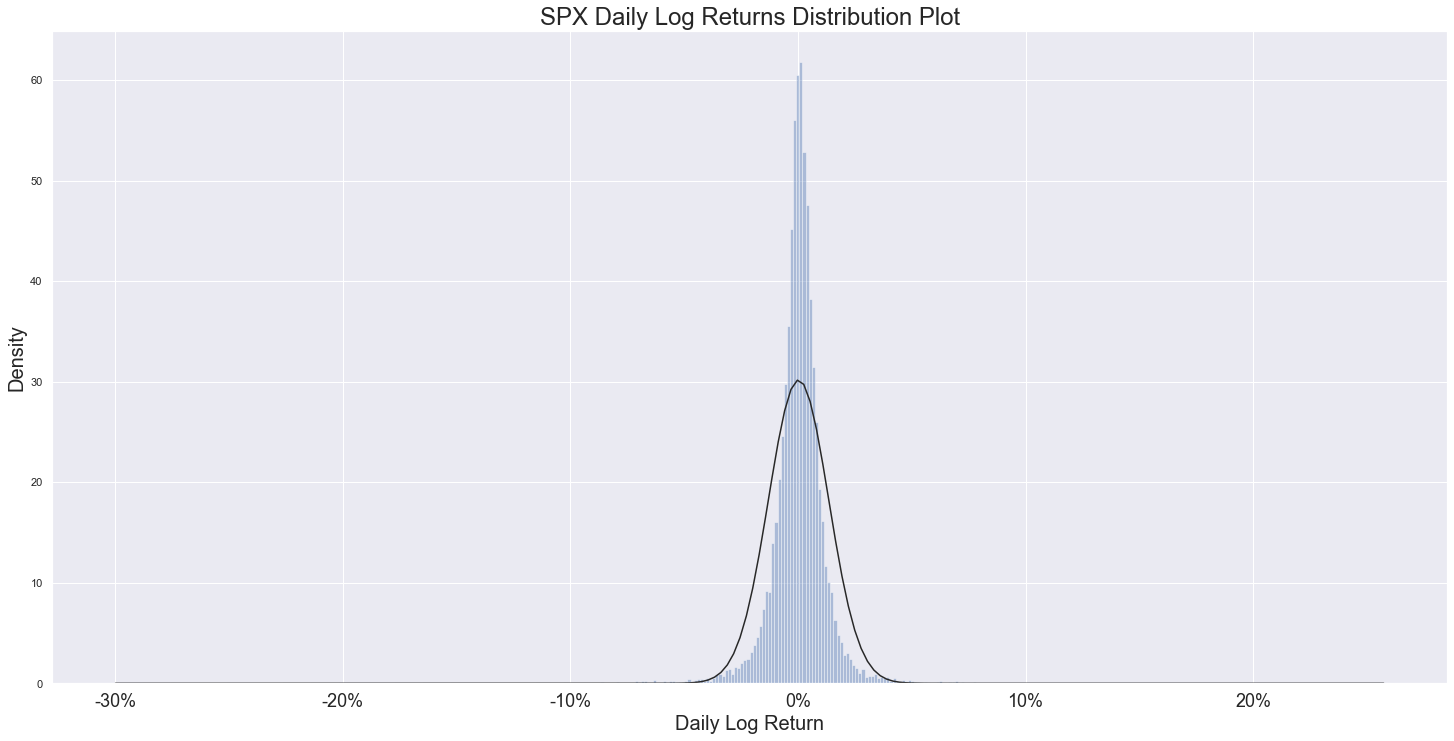

In [62]:
# usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import warnings

from scipy.integrate import simps
from scipy.interpolate import interp1d

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set()

# fetch index daily returns
DATA_PATH = './asset_data.csv'
df = pd.read_csv(DATA_PATH)
# set Date as dt format and index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['SPX']]
# compute daily log returns
df['ret'] = np.log(df['SPX'] / df['SPX'].shift(1)).dropna()


# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))
sns.distplot(df['ret'], kde=False, fit=stats.norm, ax=ax, bins=400)
# label them
ax.set_title("SPX Daily Log Returns Distribution Plot", fontsize=24)
ax.set_xlabel("Daily Log Return", fontsize=20)
ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()], fontsize=18)
ax.set_ylabel("Density", fontsize=20);

So as we can see there are many many moves between +/-2% with a very small number outside e.g. +/-4% with the distribution overall being bell-shaped. However, as shown by the fitted Normal distribution (black line) the distribution is far from normal with many more small moves than the normal would provide and more larger moves in the 'tails'. In other words, once we have an idea of the scale of the distribution (whether that's through variance or mean absolute deviation), 'large moves' can be viewed as moves that are in the tails of the distribution.

## Where does the tail start?

When we look at bell-shaped distributions, it's easy to say the tails are the thin bits on the left and right that continue ever closer to a density of 0. However theoretically deciding where they start is not such an easy task. Is it past 3 standard deviations from the mean? Or is it more like 2.5? Or maybe 4? Or does it have nothing to do with standard deviation at all?

There is no agreed upon definition of where the tail of a distribution starts. You can see [here](https://stats.stackexchange.com/questions/423330/identifying-the-tail-of-a-heavy-tailed-distribution) for 3 of the top contributors on Cross Validated (the statistics version of Stack Exchange) making this point clear to someone posing the question about where to define the start of the tail.

Whilst there may not be one agreed upon definition, we can still make use _a_ definition - this one borrowed from Nassim Taleb in the technical counterpart to his Incerto (Fooled By Randomness, Black Swan etc).

## Defining the tail

We will make the following definition:

_"The tail of a distribution begins at the point where the probability density is __convex__ to stochasticising the variance."_

In simple terms, instead of just taking a given e.g. normal distribution with a fixed mean and variance, what if we took the average of 2 normal distributions where one has a lower variance and the other has a higher variance? In a way taking the average of these 2 distributions is similar to saying that the variance is 'stochastic' (in this case just 2 states - low and high).

To do this we will do the following:
 - compute the pdf for a normal distribution with variance of `1 - e`
 - compute the pdf for a normal distribution with variance of `1 + e`
 - average them
 - repeat for various values of `e`
 
Below shows the output of this:

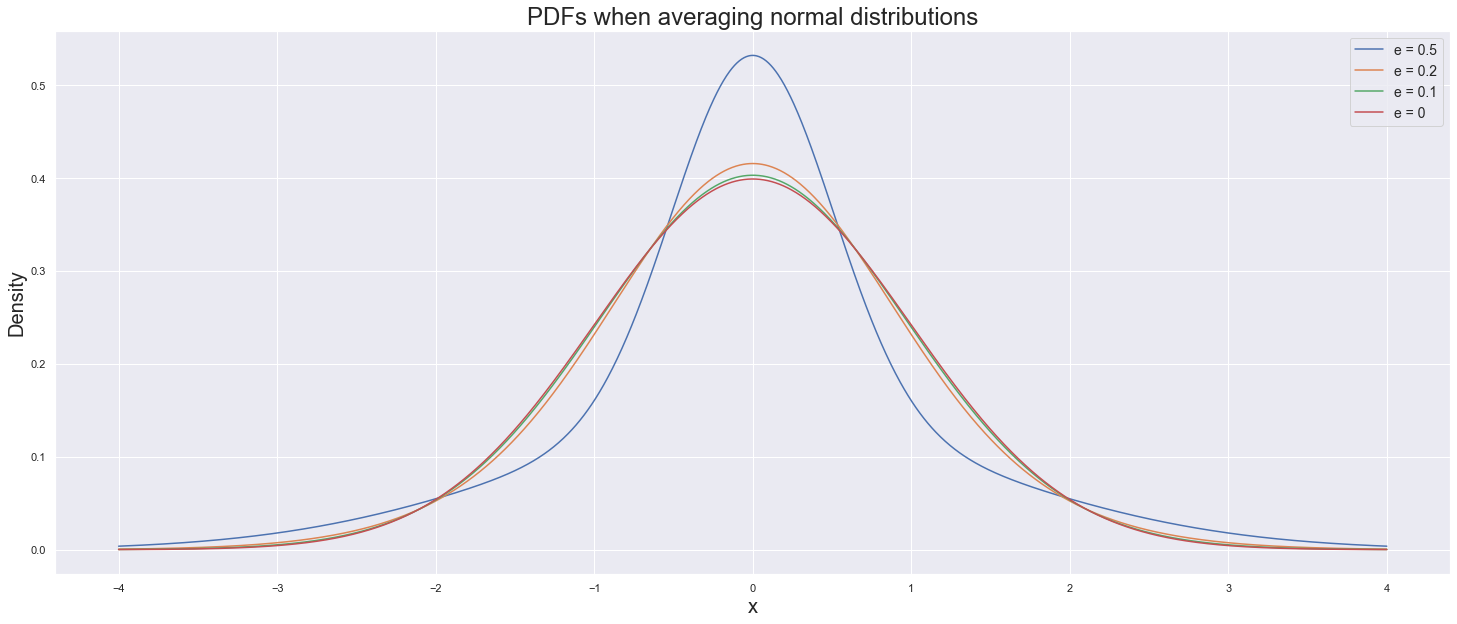

In [23]:
# define normal pdf
def norm_pdf(x, sigma=1):
    return (1 / np.sqrt(2*np.pi)) * (1 / sigma) * np.exp(-0.5 * (x/sigma)**2)

# define x's we want to compute pdf for
xs = np.linspace(-4, 4, 8*200 + 1)
# define epsilsons
eps = [0, 0.1, 0.2, 0.5]
# create pdfs
perturbs = []
for e in eps[::-1]:
    p = [0.5 * (norm_pdf(x, 1 + e) + norm_pdf(x, 1 - e)) for x in xs]
    perturbs.append([xs, p])

# plot
fig, ax = plt.subplots(figsize=(25,10))

for dist, e in zip(perturbs, eps[::-1]):
    ax.plot(dist[0], dist[1], label="e = {}".format(e))

ax.set_title("PDFs when averaging normal distributions", fontsize=24)
ax.set_xlabel("x", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.legend(fontsize=14);

The above chart shows our pdfs for various values of `e`, with `e=0` being equal to a standard normal distribution. What does it show?
 - all distributions as expected are bell-shaped
 - as we increase the value of `e` we start to get a more peaked centre around `0`
 - as we increase the value of `e` we start to get more density in the tails

But most importantly: __all versions of our distribution seem to cross at the same points__. These points are +/-0.66 stds and +/-2.13 stds and crucially we can use this to define the tails of our distribution. Using the above, we can identify the following components of a distribution:
 - the 'tails': the areas beyond +/-2.13 stds that see their probability _increase_ once we stochasticise the variance
 - the 'shoulders': the areas between +/-2.13 stds and +/-0.66 stds that see their probability _decrease_ as we stochasticise the variance
 - the 'peak/body': the area within +/-0.66 stds that we see _increase_ in probability due to stochasticising the variance

__In other words, as we fatten the tails of the distribution we do so by increasing the frequency of small moves and decreasing the frequency of medium moves.__ To come back to our original definition, the tails are convex to stochasticising the variance because as we stochasticise the variance the probability of events here increases rather than decreases.

## How does this fit in with people talking about kurtosis and fat tails?

Because kurtosis is the '4th moment' or can also be seen as the variance of variance (variance being the 2nd moment). In other words, by stochasticising the variance we are increasing the variance of the variance (from zero for the normal distribution) and so generating distributions with more kurtosis. We will see this excess kurtosis in the next section once we start sampling from these distributions to compute option prices.

## How does this impact option prices?

Alright back to the original question - how does changing the distributions in this way to have fatter tails (and so a higher probability of larger moves) effect option prices?

To do this we will:
 - create a custom distribution class in python so we can sample from these distributions
 - sample `10,000` log returns from each distribution with the same variance and mean
 - use these log returns to compute closing prices
 - compute option prices based on these 'simulations' for various strikes and see how the prices change

Below is our custom distribution class that extends the standard SciPy framework for efficient sampling - if you are curious about how this works then I've written an explainer [here](https://towardsdatascience.com/random-sampling-with-scipy-and-numpy-part-iii-8daa212ce554) on TowardsDataScience.

In [25]:
# define our gaussian look-a-like distribution
class cust_dist(stats.rv_continuous):
    
    # define init with sigma deviation param e
    def __init__(self, e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # init our variance divergence
        self.e = e
        # init our cdf and ppf functions
        self.cdf_func, self.ppf_func = self.create_cdf_ppf()
        
    # function to return normal distribution pdf
    def norm_p(self, x, loc=0, scale=1):
        return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * 2.5066282746310002)
        
    # function to normalise the pdf over chosen domain
    def normalisation(self, x):
        return simps(self.pdf(x), x)
    
    # function to
    def create_cdf_ppf(self):
        # define domain as +/-25 sigma
        xs = np.linspace(-25, 25, 10000001)
        # normalise our pdf to sum to 1 so it satisfies a distribution
        norm_constant = self.normalisation(xs)
        # compute pdfs to be summed to form cdf
        my_pdfs = self.pdf(xs) / norm_constant
        # cumsum to form cdf
        my_cdf = np.cumsum(my_pdfs)
        # make sure cdf bounded on [0,1]
        my_cdf = my_cdf / my_cdf[-1]
        # create cdf and ppf
        func_cdf = interp1d(xs, my_cdf)
        func_ppf = interp1d(my_cdf, xs, fill_value='extrapolate')
        return func_cdf, func_ppf
        
    # pdf function for averaged normals
    def _pdf(self, x):
        # define lower var distribution prob
        low = self.norm_p(x, scale=(1 - self.e)**0.5)
        # define higher var distribution prob
        high = self.norm_p(x, scale=(1 + self.e)**0.5)
        return 0.5 * (low + high)
    
    # cdf function
    def _cdf(self, x):
        return self.cdf_func(x)
    
    # inverse cdf function
    def _ppf(self, x):
        return self.ppf_func(x)

Now, assuming we have a stock with `S=100` and an annual volatility of `20%`, let's simulate `10,000` year end stock prices according to:

$$ \frac{dS_t}{S_t} = \sigma dW_t $$

i.e. a Geometric Brownian Motion (GBM) with no drift. We will just simulate one period (i.e. the whole year in one step) and so this amounts to choosing `10,000` returns from our given distribution and using them to compute year end stock prices as:

$$ S_T = S_0 e^r $$

where `r` is the random number we have plucked from our distributions.

Let's now do the following - compute option values for a variety of strikes based on year end prices generated by each of the above distributions. Note we'll only compute time value of options to prevent the picture being muddied by intrinsic value. To do that we'll just compute put prices for strikes below `100`, and call prices for `100` and above.

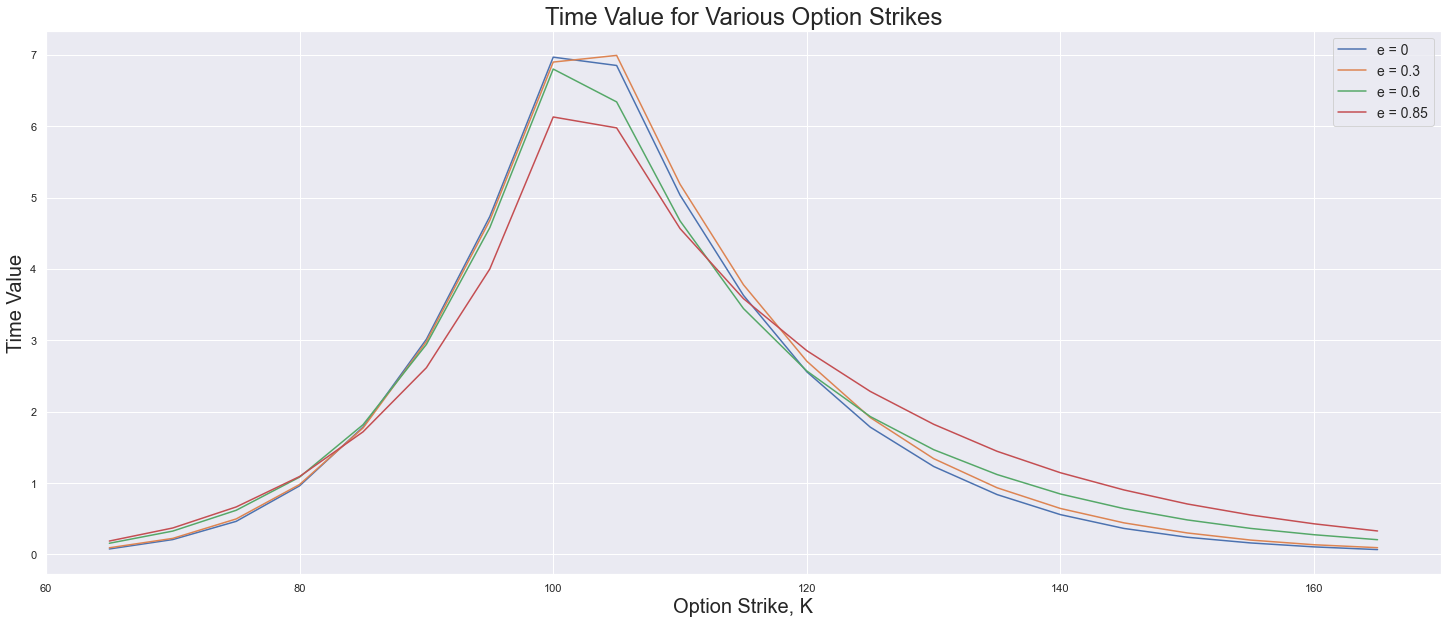

In [68]:
# set stock params
spot = 100
sigma = 0.20
n = 10000
# option strikes
ks = np.linspace(65, 165, 21)
eps = [0, 0.3, 0.6, 0.85]

# compute closing prices
pxs = {}
op_pxs = {}
for e in eps:
    # init distribution class
    dist = cust_dist(e=e)
    # sample returns from dist
    rets = sigma * dist.rvs(size=n)
    # compute prices
    px = spot * np.exp(rets)
    # add pxs to price dict
    pxs[e] = px
    # compute option pxs
    op_px = [np.mean([max(x - k, 0) if k > spot else max(k - x, 0) for x in px]) for k in ks]
    # add to option price dict
    op_pxs[e] = op_px

# plot them
fig, ax = plt.subplots(figsize=(25,10))

for e, op_px in op_pxs.items():
    ax.plot(ks, op_px, label="e = {}".format(e))

ax.set_title("Time Value for Various Option Strikes", fontsize=24)
ax.set_xlabel("Option Strike, K", fontsize=20)
ax.set_ylabel("Time Value", fontsize=20)
ax.legend(fontsize=14);

The above shows how the time value of these options varies as we vary the distributions to become increasingly fat tailed. The blue line shows us the default under the assumption of normality i.e. `e=0`. As we increase `e` and as a result fatten the tails of the distribution we generate our log returns from we can see that 2 things happen:
 - as expected the time value (and hence total value) of options with strikes away from our starting spot (`S=100`) _increase_ in value
 - the value of options with strikes close to our starting spot actually _decrease_ in value as we fatten the tails

So it seems like there are some options that actually don't benefit from increasing the probability of having 'large moves'. Why? Because we've reduced the probability of generating 'medium moves' in order to facilitate this tail fattening as shown above by our distributions losing their 'shoulders'.

It might look like the changes in time value are fairly small, but we can re-plot the above by comparing our fattened distributions vs the normal and so plotting percentage changes in time value.

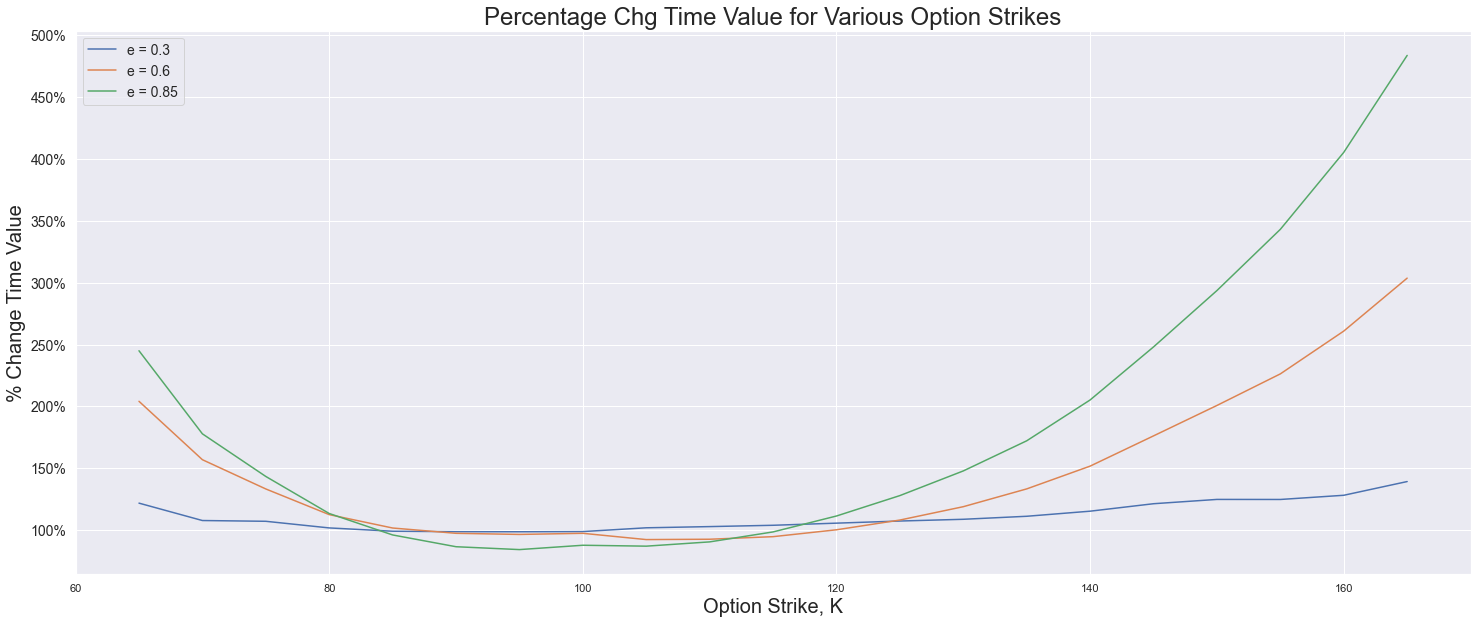

In [71]:
# plot them
fig, ax = plt.subplots(figsize=(25,10))

for e, op_px in op_pxs.items():
    if e != 0:
        ax.plot(ks, [x/y for x,y in zip(op_px, op_pxs[0])], label="e = {}".format(e))

ax.set_title("Percentage Chg Time Value for Various Option Strikes", fontsize=24)
ax.set_xlabel("Option Strike, K", fontsize=20)
ax.set_ylabel("% Change Time Value", fontsize=20)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()], fontsize=14)
ax.legend(fontsize=14);

## Conclusion

When seen like this we can see that 'wing options' - options with strikes far away from the current spot (or more accurately the current forward) - are the true beneficiaries of tail fattening. In reality this is what is being talked about when talking about options displaying true convexity.

These are the options that were being traded by the WallStreetBets gang on GME, these are the options that are seen to deliver huge profits in 'tail events' and these are the options that deliver the convexity that is idolised in movies like the Big Short.